In [10]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn import model_selection
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
import PIL as pillow
import wordcloud

In [12]:
unordered = pd.read_csv('../part-02/cleaned_speeches_and_party.csv')

In [13]:
df = unordered[['speakers', 'person_id', 'debate_id', 'dates', 'constituency', 'party', 'headings', 'speeches']]

In [14]:
df.columns = ['mp', 'person_id', 'debate_id', 'date', 
   'constituency', 'party', 'topic', 'text']

In [15]:
df.head()

,mp,person_id,debate_id,date,constituency,party,topic,text
0,Brandon Lewis,24879,2020-01-07a,2020-01-07,Great Yarmouth,Conservative,None,Let me finish the point. It takes five to 10 m...
1,Brandon Lewis,24879,2020-01-07a,2020-01-07,Great Yarmouth,Conservative,None,I will be brief; I just want to respond to a c...
2,Lindsay Hoyle,10295,2020-01-07b,2020-01-07,Chorley,Speaker,Speaker’s Statement,"On behalf of the whole House, I wish to expres..."
3,Lindsay Hoyle,10295,2020-01-07b,2020-01-07,Chorley,Labour,Speaker’s Statement,"On behalf of the whole House, I wish to expres..."
4,Mark Logan,25886,2020-01-07b,2020-01-07,Bolton North East,Conservative,Per Pupil Funding,Whether he plans to increase the level of per ...


In [16]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

In [17]:
df.head()

,mp,person_id,debate_id,date,constituency,party,topic,text,word_count
0,Brandon Lewis,24879,2020-01-07a,2020-01-07,Great Yarmouth,Conservative,None,Let me finish the point. It takes five to 10 m...,136
1,Brandon Lewis,24879,2020-01-07a,2020-01-07,Great Yarmouth,Conservative,None,I will be brief; I just want to respond to a c...,162
2,Lindsay Hoyle,10295,2020-01-07b,2020-01-07,Chorley,Speaker,Speaker’s Statement,"On behalf of the whole House, I wish to expres...",340
3,Lindsay Hoyle,10295,2020-01-07b,2020-01-07,Chorley,Labour,Speaker’s Statement,"On behalf of the whole House, I wish to expres...",340
4,Mark Logan,25886,2020-01-07b,2020-01-07,Bolton North East,Conservative,Per Pupil Funding,Whether he plans to increase the level of per ...,11


In [18]:
processed = df['text'].str.replace(r'^.+[^\.].*\.[a-z]{2,}$',' ')
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
processed = processed.str.replace(r'http',' ')
processed = processed.str.replace(r'£|\$', ' ')
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ')
processed = processed.str.replace(r'\d+(\.\d+)?', ' ')
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', ' ')
processed = processed.str.lower()
processed.head()

0    let me finish the point it takes five to minut...
1    i will be brief i just want to respond to a co...
2    on behalf of the whole house i wish to express...
3    on behalf of the whole house i wish to express...
4    whether he plans to increase the level of per ...
Name: text, dtype: object

In [19]:
df['text'] = processed

We are not interested in the Speaker of the house so we will drop all rows containing data labelled with Speaker in the party column.

In [20]:
df = df.drop(df[df.party == 'Speaker'].index).reset_index()

At this point, the features that I am most interested in are the topic, text and of course the party (my target variable).

Lets begin with a quick visualisation of my text data, I am going to use a word count visualisation to look at the most frequently occurring words. 

In [21]:
df.party.unique()

array(['Conservative', 'Labour', 'Liberal Democrat',
       'Scottish National Party', 'Labour/Co-operative', 'DUP',
       'Independent', 'Green', 'Plaid Cymru', 'Alliance',
       'Social Democratic and Labour Party', 'UUP', 'UKIP'], dtype=object)

In [22]:
df.party.value_counts()

Conservative                          85955
Labour                                32290
Scottish National Party               10171
Labour/Co-operative                    5579
Liberal Democrat                       2722
DUP                                    2186
Independent                             800
Plaid Cymru                             719
Green                                   311
Social Democratic and Labour Party      231
UUP                                     129
UKIP                                     23
Alliance                                 23
Name: party, dtype: int64

In [23]:
df.party.value_counts(normalize=True)

Conservative                          0.609010
Labour                                0.228782
Scottish National Party               0.072064
Labour/Co-operative                   0.039528
Liberal Democrat                      0.019286
DUP                                   0.015488
Independent                           0.005668
Plaid Cymru                           0.005094
Green                                 0.002204
Social Democratic and Labour Party    0.001637
UUP                                   0.000914
UKIP                                  0.000163
Alliance                              0.000163
Name: party, dtype: float64

In [24]:
len(df.topic.unique())

3245

In [25]:
df.topic.value_counts()[:30]

BUSINESS OF THE HOUSE                       5251
PRIME MINISTER                              2977
Topical Questions                           2770
None                                        1984
Business of the House                       1467
DEBATE ON THE ADDRESS                       1075
EUROPEAN UNION (WITHDRAWAL) BILL            1069
PRAYERS - \n[Mr Speaker in the Chair]       1004
Engagements                                  969
EUROPEAN COUNCIL                             850
Prime Minister                               734
POINTS OF ORDER                              682
LEAVING THE EU                               658
Points of Order                              592
BUSINESS OF THE HOUSE (TODAY)                531
FINANCE BILL                                 524
“Creation of UK-wide frameworks              499
BUDGET RESOLUTIONS - INCOME TAX (CHARGE)     497
EU EXIT NEGOTIATIONS                         492
YEMEN                                        477
EXITING THE EUROPEAN

At this point it is important to reflect on the goal of the project. The goal of this project is to be able to predict political party from transcripts of house of commons debates. 

After looking at Conservative, Labour, SNP and Labour/Co-Operative speakers, individual parties make up less than 2% of the data and colaboratively just over 5%. 

Due to the limited data of most of the parties, I will run models with all parties and then again with a binary target variable - Conservatives vs Labour. 

In [26]:
cvec = CountVectorizer()
cvec.fit(df.text)

CountVectorizer()

In [27]:
len(cvec.get_feature_names())

60649

In [46]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words= stop)

# Fit our vectorizer using our train data
cvec.fit(df.text)

# Transform training data
cvec_mat = cvec.transform(df.text)

# words occuring
words = cvec.get_feature_names()
print(words[5000:5020])
print()
# number of different words
print(len(words))

['benzoate', 'benzodiazepine', 'benzodiazepines', 'bepa', 'beps', 'bequ', 'bequeath', 'bequeathed', 'bequeathing', 'bequest', 'bequests', 'berate', 'berated', 'berates', 'berating', 'bercow', 'berdiansk', 'berdyansk', 'bereaved', 'bereavement']

60494


In [47]:
a = cvec_mat.sum(axis=0)
pd.DataFrame(a, columns=words).transpose().sort_values(by=0, ascending=False)[:20]

,0
government,96146
people,79124
would,65465
minister,51143
house,48769
one,40596
work,37957
need,36980
many,36422
us,34772


In [48]:
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

In [49]:
csum = word_counter(cvec_mat)
csum

array([28,  1,  2, ...,  4,  1,  2])

In [50]:
from operator import itemgetter


def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [51]:
df_word_frequency = pd.DataFrame(word_frequency_sorter(
    words, csum), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.head(20)

,frequency
word,
government,96146
people,79124
would,65465
minister,51143
house,48769
one,40596
work,37957
need,36980
many,36422


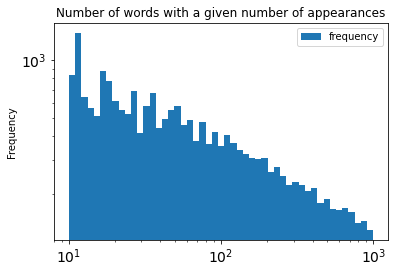

In [52]:
df_word_frequency.plot(kind='hist',
                       bins=np.logspace(1, 3, 50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14)
plt.show()

In [53]:
df_word_frequency = {}
for i,j in zip(range(len(df.party.unique())), df.party.unique()):
    csum_i = word_counter(cvec_mat[df.party == j, :])

    df_word_frequency[i] = pd.DataFrame(word_frequency_sorter(
        words, csum_i), columns=['word', 'frequency'])
    df_word_frequency[i].set_index('word', inplace=True)
    print(df.party.unique()[i])
    print(df_word_frequency[i].head(10))
    print()

Conservative
            frequency
word                 
government      42814
people          41622
would           36084
house           26868
work            24069
one             22448
need            19894
make            19880
also            19558
minister        19314

Labour
            frequency
word                 
government      31601
people          21959
minister        19311
would           16752
house           13425
secretary       12200
one             10781
many            10505
state           10442
need            10226

Liberal Democrat
            frequency
word                 
government       2188
people           1914
would            1588
minister         1405
house             963
one               955
many              886
us                834
need              773
secretary         761

Scottish National Party
            frequency
word                 
government      12085
people           6986
scotland         6514
uk               6110
minister    

In [20]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

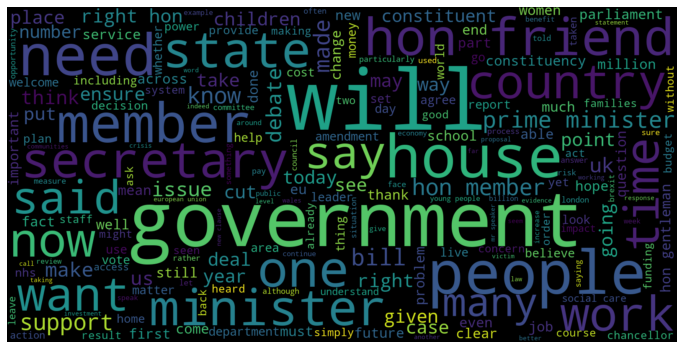

In [14]:
labour_speeches = df[df.party == 'Labour']
labour_string = []
for t in labour_speeches.text:
    labour_string.append(t)
labour_string = pd.Series(labour_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(labour_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

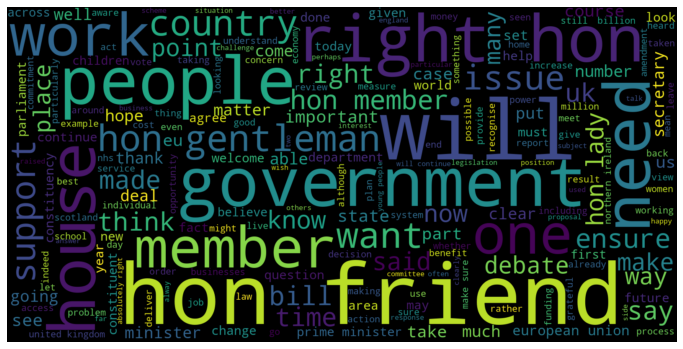

In [25]:
tory_speeches = df[df.party == 'Conservative']
tory_string = []
for t in tory_speeches.text:
    tory_string.append(t)
tory_string = pd.Series(tory_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tory_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

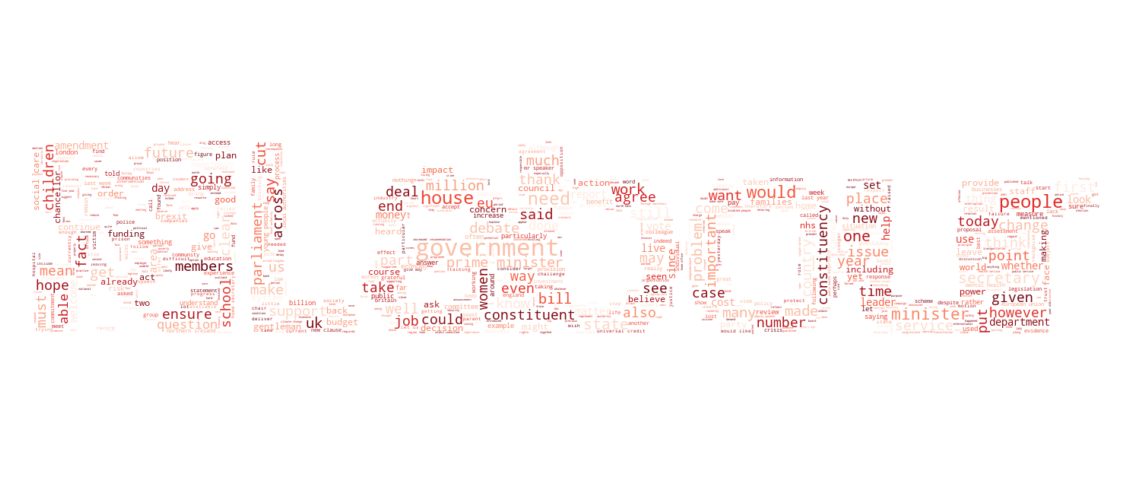

In [59]:
mask = np.array(Image.open('Labour-Logo.jpg'))
wc = WordCloud(colormap = 'Reds', stopwords = stop,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(labour_string)
plt.figure(figsize=(20,15))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

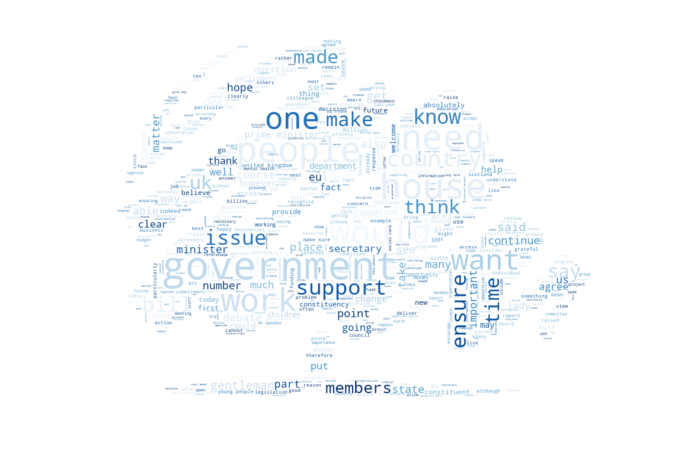

In [57]:
mask = np.array(Image.open('tory-logo.png'))
wc = WordCloud(colormap = 'Blues', stopwords = stop,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(tory_string)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [37]:
stop = stopwords.words('english')
stop = stop + ['conservative','conservatives','tory','tories','labour','corbyn', 'hon', 'friend', 'johnson', 'member', 'honerable', 'right']

In [41]:
df.party.value_counts(normalize=True)

Conservative                          0.582991
Labour                                0.219007
Scottish National Party               0.068985
Speaker                               0.042723
Labour/Co-operative                   0.037840
Liberal Democrat                      0.018462
DUP                                   0.014827
Independent                           0.005426
Plaid Cymru                           0.004877
Green                                 0.002109
Social Democratic and Labour Party    0.001567
UUP                                   0.000875
UKIP                                  0.000156
Alliance                              0.000156
Name: party, dtype: float64

In [43]:
df.head()

,mp,person_id,debate_id,date,constituency,party,topic,text
0,Brandon Lewis,24879,2020-01-07a,2020-01-07,Great Yarmouth,Conservative,None,let me finish the point it takes five to minut...
1,Brandon Lewis,24879,2020-01-07a,2020-01-07,Great Yarmouth,Conservative,None,i will be brief i just want to respond to a co...
2,Lindsay Hoyle,10295,2020-01-07b,2020-01-07,Chorley,Speaker,Speaker’s Statement,on behalf of the whole house i wish to express...
3,Lindsay Hoyle,10295,2020-01-07b,2020-01-07,Chorley,Labour,Speaker’s Statement,on behalf of the whole house i wish to express...
4,Mark Logan,25886,2020-01-07b,2020-01-07,Bolton North East,Conservative,Per Pupil Funding,whether he plans to increase the level of per ...


Weak Model 

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords

import scikitplot as skplt

In [44]:
train_df, test_df = train_test_split(df, stratify=df['party'], test_size=0.2, random_state=1)

In [45]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode',stop_words=stop)),
#     ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 

pipeline.fit(df.text, df.party)
print(pipeline.score(df.text, df.party))
print(cross_val_score(pipeline, df.text, df.party, cv=5).mean())
print(pipeline.score(df.text, df.party))

0.7007352242976709
0.6560723300156311
0.7007352242976709


In [46]:
predictions = pipeline.predict(df.text)
pd.DataFrame(confusion_matrix(df.party, predictions,
                              labels=df.party.unique()),
             columns=df.party.unique(),
             index=df.party.unique())

,Conservative,Speaker,Labour,Liberal Democrat,Scottish National Party,Labour/Co-operative,DUP,Independent,Green,Plaid Cymru,Alliance,Social Democratic and Labour Party,UUP,UKIP
Conservative,72995,1895,6860,146,2859,398,731,49,1,21,0,0,0,0
Speaker,1089,5030,144,2,23,3,7,1,0,0,0,0,0,0
Labour,10872,1684,17596,50,1545,268,256,7,0,12,0,0,0,0
Liberal Democrat,1291,38,808,252,289,20,21,1,0,2,0,0,0,0
Scottish National Party,2978,152,1533,5,5407,43,51,1,0,1,0,0,0,0
Labour/Co-operative,2206,86,2000,8,253,995,30,0,1,0,0,0,0,0
DUP,999,9,197,0,74,12,895,0,0,0,0,0,0,0
Independent,380,12,144,6,76,6,104,37,0,35,0,0,0,0
Green,136,2,127,2,36,6,1,0,1,0,0,0,0,0
Plaid Cymru,291,10,195,7,93,7,5,5,0,106,0,0,0,0


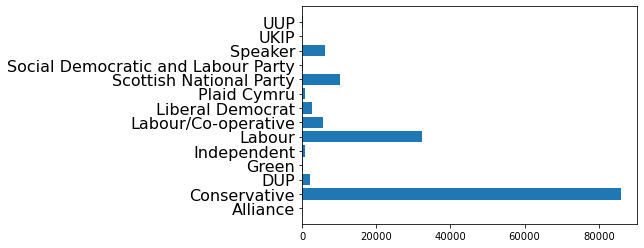

In [55]:
plt.barh(*np.unique(df.party, return_counts=True))

plt.yticks(fontsize=16)
plt.show()

POS Tagging - how many verbs or nouns per sentence
